# This is the processing pipeline for the looking at glioblastome differentation

## Initial setup:
Initial setup for our required packages and setting how verbose our errors should be.
During install, you may need to use ```pip``` rather thna ```pip3```, depends on how python is installed on your system (and what verions you have).

Also, we are suppressing some terminal output using ```grep``` (so the output looks a little cleaner).

In [1]:
!pip3 install numpy | grep -v 'already satisfied'
!pip3 install pandas | grep -v 'already satisfied'
!pip3 install seaborn | grep -v 'already satisfied'
!pip3 install scanpy | grep -v 'already satisfied'

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.1 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [2]:
!cd ../ && ls

NGC-DL-CONTAINER-LICENSE  dev	lib32	mnt	   root  storage  var
bin			  etc	lib64	notebooks  run	 sys
boot			  home	libx32	opt	   sbin  tmp
datasets		  lib	media	proc	   srv	 usr


## Reading Data In
We were only given filtered ```.h5``` files to work with (the unfiltered files seemed to be corrupted). 
This is not ideal as I do not know what steps were taken for this filtering but we will work with it to the best of out ability.

We have the option to do our analysis with only human genes, but we have deciced to include the rat endothelial cells as well.
When testing to see if it made a difference (see the bottom of the notebook), it seemed to be negligible either way.

We are going to mark the human and rat genomes so we can filter by them later in visualization.

If you are storing the data in a nested folder, just fill in ```file_location```.

In [4]:
# Aprrox. 1 sec per read
# file_location = ''
# data_1914 = '1914/filtered_feature_bc_matrix.h5'
# data_1914d = '1914d/filtered_feature_bc_matrix.h5'
# data_1919 = '1919/filtered_feature_bc_matrix.h5'
# data_1919d = '1919d/filtered_feature_bc_matrix.h5'

# For remote server
file_location = '../datasets/'
data_1914 = 'data_1914/filtered_feature_bc_matrix.h5'
data_1914d = 'data_1914d/filtered_feature_bc_matrix.h5'
data_1919 = 'data_1919/filtered_feature_bc_matrix.h5'
data_1919d = 'data_1919d/filtered_feature_bc_matrix.h5'



adata_1914_human = sc.read_10x_h5(
    file_location + data_1914,
    genome='GRCh38')
adata_1914d_human = sc.read_10x_h5(
    file_location + data_1914d,
    genome='GRCh38')
adata_1919_human = sc.read_10x_h5(
    file_location + data_1919,
    genome='GRCh38')
adata_1919d_human = sc.read_10x_h5(
    file_location + data_1919d,
    genome='GRCh38')

adata_1914_rat = sc.read_10x_h5(
    file_location + data_1914,
        genome='mRatBN7.2')
adata_1914d_rat = sc.read_10x_h5(
    file_location + data_1914d,
    genome='mRatBN7.2')
adata_1919_rat = sc.read_10x_h5(
    file_location + data_1919,
    genome='mRatBN7.2')
adata_1919d_rat = sc.read_10x_h5(
    file_location + data_1919d,
    genome='mRatBN7.2')




reading ../datasets/data_1914/filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../datasets/data_1914d/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading ../datasets/data_1919/filtered_feature_bc_matrix.h5
 (0:00:01)
reading ../datasets/data_1919d/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading ../datasets/data_1914/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading ../datasets/data_1914d/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading ../datasets/data_1919/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading ../datasets/data_1919d/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Checking Names
It is common for data to be prepended with labels. This is often a product of off the shelf software and can make things harder to work with if you don't remove them. 

We are just going to quickly check and remove if neccesarry.

In [5]:
# View the first 5 rows of the data
adata_1914_human.var.head()
# adata_1914_human.obs.head()



,gene_ids,feature_types,genome
GRCh38____TNFRSF4,GRCh38____ENSG00000186827,Gene Expression,GRCh38
GRCh38____TNFRSF18,GRCh38____ENSG00000186891,Gene Expression,GRCh38
GRCh38____ATAD3B,GRCh38____ENSG00000160072,Gene Expression,GRCh38
GRCh38____ENSG00000260179,GRCh38____ENSG00000260179,Gene Expression,GRCh38
GRCh38____ENSG00000234396,GRCh38____ENSG00000234396,Gene Expression,GRCh38


### Result:
We see that everything is either prepended by ```GRCh38____``` or ```mRatBN7.2_```. 
Thankfully, it seems that whoever did the previous analysis made sure these prepended labels were always ten charecters by adding underscores, so we can just strip the first ten charecters off all the gene_ids.

## Cleaning Up, Step 1
The first thing we are going to do is strip the first ten charecters from all the gene_ids. 

Then we are going to ensure that all the gene_ids are unique in the respective datasets.

In [6]:
# filter the GRCh38__ from the front of names
adata_1914_human.var_names = [name[10:] for name in adata_1914_human.var_names]
adata_1914d_human.var_names = [name[10:] for name in adata_1914d_human.var_names]
adata_1919_human.var_names = [name[10:] for name in adata_1919_human.var_names]
adata_1919d_human.var_names = [name[10:] for name in adata_1919d_human.var_names]
adata_1914_rat.var_names = [name[10:] for name in adata_1914_rat.var_names]
adata_1914d_rat.var_names = [name[10:] for name in adata_1914d_rat.var_names]
adata_1919_rat.var_names = [name[10:] for name in adata_1919_rat.var_names]
adata_1919d_rat.var_names = [name[10:] for name in adata_1919d_rat.var_names]


# make the gene names unique
adata_1914_human.var_names_make_unique()
adata_1914d_human.var_names_make_unique()
adata_1919_human.var_names_make_unique()
adata_1919d_human.var_names_make_unique()
adata_1914_rat.var_names_make_unique()
adata_1914d_rat.var_names_make_unique()
adata_1919_rat.var_names_make_unique()
adata_1919d_rat.var_names_make_unique()



## Combine
We will combine rat and human, while preserving some annotation so we can filter by them later. 

We also want to combine 1914 and 1914d (same with 1919) to compare them. 

Finally, we want to combine 1914 with 1919 to form a single dataset. This means we will have to be extra careful with our normalization steps.

In [7]:
# Quick Check:
adata_1914_human.var.head()

,gene_ids,feature_types,genome
TNFRSF4,GRCh38____ENSG00000186827,Gene Expression,GRCh38
TNFRSF18,GRCh38____ENSG00000186891,Gene Expression,GRCh38
ATAD3B,GRCh38____ENSG00000160072,Gene Expression,GRCh38
ENSG00000260179,GRCh38____ENSG00000260179,Gene Expression,GRCh38
ENSG00000234396,GRCh38____ENSG00000234396,Gene Expression,GRCh38


In [8]:
# Aprrox. 0.5 sec per combination

# adata_1914_combined = adata_1914_human.concatenate(adata_1914_rat, adata_1914d_human, adata_1914d_rat, batch_categories=['1914_human', '1914_rat', '1914d_human', '1914d_rat'])
# adata_1919_combined = adata_1919_human.concatenate(adata_1919_rat, adata_1919d_human, adata_1919d_rat, batch_categories=['1919_human', '1919_rat', '1919d_human', '1919d_rat'])

# adata_undifferentiated_combined = adata_1914_human.concatenate(adata_1914_rat, adata_1919_human, adata_1919_rat, batch_categories=['1914_human', '1914_rat', '1919_human', '1919_rat'])
# adata_differentiated_combined = adata_1914d_human.concatenate(adata_1914d_rat, adata_1919d_human, adata_1919d_rat, batch_categories=['1914d_human', '1914d_rat', '1919d_human', '1919d_rat'])

adata_combined = adata_1914_human.concatenate(adata_1914_rat, adata_1914d_human, adata_1914d_rat, adata_1919_human, adata_1919_rat, adata_1919d_human, adata_1919d_rat, batch_categories=['1914_human', '1914_rat', '1914d_human', '1914d_rat', '1919_human', '1919_rat', '1919d_human', '1919d_rat'], join='outer')

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [9]:
# Some quick checking:
# adata_1914_combined.obs.batch.value_counts()
# adata_1919_combined.obs.batch.value_counts()
adata_combined.obs.batch.value_counts()


1914_human     9513
1914_rat       9513
1914d_human    8925
1914d_rat      8925
1919_human     7610
1919_rat       7610
1919d_human    7278
1919d_rat      7278
Name: batch, dtype: int64

### Results Files
It has become standard practice to use ```.h5ad``` files to group all our results and steps together in a single file.

I personally do not like this, but this is standard practice in the field.

Make sure to uncomment anything you want here, and in the previous code blocks.

Afterwards simply choose what you want to run it on by including it in the ```running_on``` array, and where you want to save it in the ```saving_to``` array.

In [10]:
rf_total_combined = 'write/total_combined.h5ad'

running_on = [adata_combined]
saving_to = [rf_total_combined]

In [11]:
# We want to quickly write everything to our results files:
def write_results(running_on, saving_to):
    for i in range(len(running_on)):
        running_on[i].write(saving_to[i])
        print('Wrote to ' + saving_to[i])

In [12]:
write_results(running_on, saving_to)

Wrote to write/total_combined.h5ad


In [13]:
adata_combined.var_names

Index(['0610030E20Rik', '0610040J01Rik', '1110002E22Rik', '1110032F04Rik',
       '1110038F14Rik', '1110065P20Rik', '1500009L16Rik', '1600012H06Rik',
       '1600014C10Rik', '1700001P01Rik',
       ...
       'Zzz3', 'dsr-2', 'hsa-mir-1253', 'hsa-mir-423', 'mrpl11', 'mrpl24',
       'mrpl9', 'pramef20l', 'rnf141', 'tGap1'],
      dtype='object', length=82518)

## Filtering
Since, we don't know how things were filitered to begin with, we are just going to do some basic filtering:
1) Filter any cells that have less than 200 genes expressed.
2) Filter any genes that are expressed in less than 2 cells.
3) Annotating any known mitochondrial genes, as they introduce unncessary noise.
4) Filter out any cells with more than 2500 genes.
5) Filter out any cells of which more than 5% of their genes are mitochondrial.

We are also computing QC metrics that we will use throughout. These include:
1) total_genes_by_count: single number for how many genes are present in a cell.
2) n_genes_by_count: single number for the number of genes with at least 1 count in a cell.
3) total_counts: a single number for the total amount of counts expressed by every gene in a cell.
4) pct_counts_mt: The proportion of total counts for a cell which are from mitochondrial genes.

There are others, but are not important for now...


In [14]:

# filter cells with less than 200 genes expressed
def filter_200(running_on):
    for item in running_on:
        sc.pp.filter_cells(item, min_genes=200)
    
# filter genes expressed in less than 2 cells
def filter_2(running_on):
    for item in running_on:
        sc.pp.filter_genes(item, min_cells=2)
        

In [15]:
# Aprrox. 2.5 sec per group
filter_200(running_on)

filtered out 41529 cells that have less than 200 genes expressed


In [16]:
# Aprrox. 0.5 sec per group
filter_2(running_on)

filtered out 34764 genes that are detected in less than 2 cells


In [17]:

# annotate the group of mitochondrial genes as 'mt'
def annotate_mt(running_on):
    for item in running_on:
        item.var['mt'] = item.var_names.str.startswith('MT-')
# compute QC metrics for all datasets
def qc_metrics(running_on):
    for item in running_on:
        sc.pp.calculate_qc_metrics(item, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    

In [18]:

# Aprrox. 0.5 sec per group
annotate_mt(running_on)


In [19]:
# Aprrox. 0.5 sec per group
qc_metrics(running_on)

In [20]:

# filter cells with more than 2500 genes
def filter_2500(running_on):
    for item in running_on:
        item = item[item.obs.n_genes_by_counts < 2500, :]

# filter cells with more than 5% mitochondrial genes
def filter_5_mt(running_on):
    for item in running_on:
        item = item[item.obs.pct_counts_mt < 5, :]


In [21]:
# Aprrox. 0.5 sec per group
filter_2500(running_on)

In [22]:
# Aprrox. 0.5 sec per group
filter_5_mt(running_on)

In [23]:
# Some extra checks:
adata_combined.var

,gene_ids-1914_human,feature_types-1914_human,genome-1914_human,gene_ids-1914_rat,feature_types-1914_rat,genome-1914_rat,gene_ids-1914d_human,feature_types-1914d_human,genome-1914d_human,gene_ids-1914d_rat,...,genome-1919d_human,gene_ids-1919d_rat,feature_types-1919d_rat,genome-1919d_rat,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
0610030E20Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000011713,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000011713,...,NaN,mRatBN7.2_ENSRNOG00000011713,Gene Expression,mRatBN7.2,50,False,50,0.002149,99.800979,54.0
1110038F14Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000034107,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000034107,...,NaN,mRatBN7.2_ENSRNOG00000034107,Gene Expression,mRatBN7.2,7,False,7,0.000279,99.972137,7.0
1110065P20Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000042421,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000042421,...,NaN,mRatBN7.2_ENSRNOG00000042421,Gene Expression,mRatBN7.2,4,False,4,0.000159,99.984078,4.0
1600012H06Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000070184,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000070184,...,NaN,mRatBN7.2_ENSRNOG00000070184,Gene Expression,mRatBN7.2,11,False,11,0.000478,99.956215,12.0
1600014C10Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000014966,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000014966,...,NaN,mRatBN7.2_ENSRNOG00000014966,Gene Expression,mRatBN7.2,2,False,2,0.000119,99.992039,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000050321,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000050321,...,NaN,mRatBN7.2_ENSRNOG00000050321,Gene Expression,mRatBN7.2,24,False,24,0.000995,99.904470,25.0
mrpl11,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000019970,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000019970,...,NaN,mRatBN7.2_ENSRNOG00000019970,Gene Expression,mRatBN7.2,4,False,4,0.000159,99.984078,4.0
mrpl24,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000022234,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000022234,...,NaN,mRatBN7.2_ENSRNOG00000022234,Gene Expression,mRatBN7.2,38,False,38,0.001632,99.848744,41.0
mrpl9,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000020869,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000020869,...,NaN,mRatBN7.2_ENSRNOG00000020869,Gene Expression,mRatBN7.2,14,False,14,0.000637,99.944274,16.0


## Checking QC Metrics
We are just going to do some quick visualization for QC metrics.

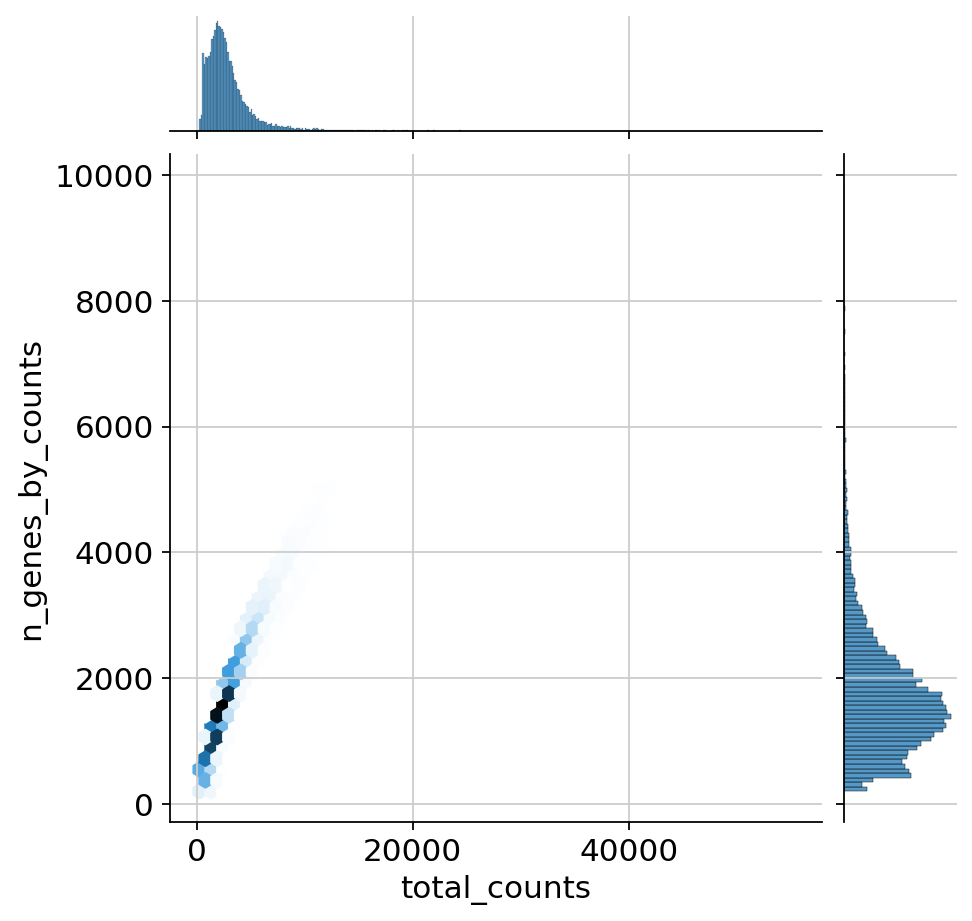

In [24]:

plot1 = sns.jointplot(
        data=adata_combined.obs,
        x="total_counts",
        y="n_genes_by_counts",
        kind="hex",
    )



<AxesSubplot:xlabel='pct_counts_mt', ylabel='Count'>

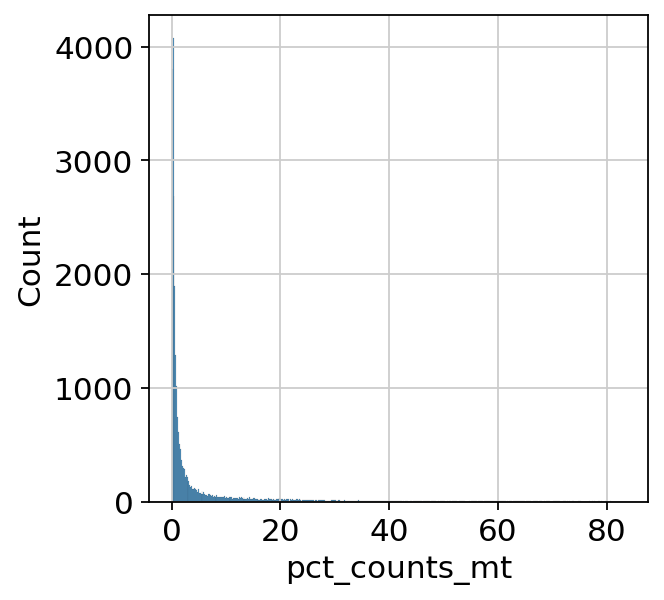

In [25]:
sns.histplot(adata_combined.obs["pct_counts_mt"])


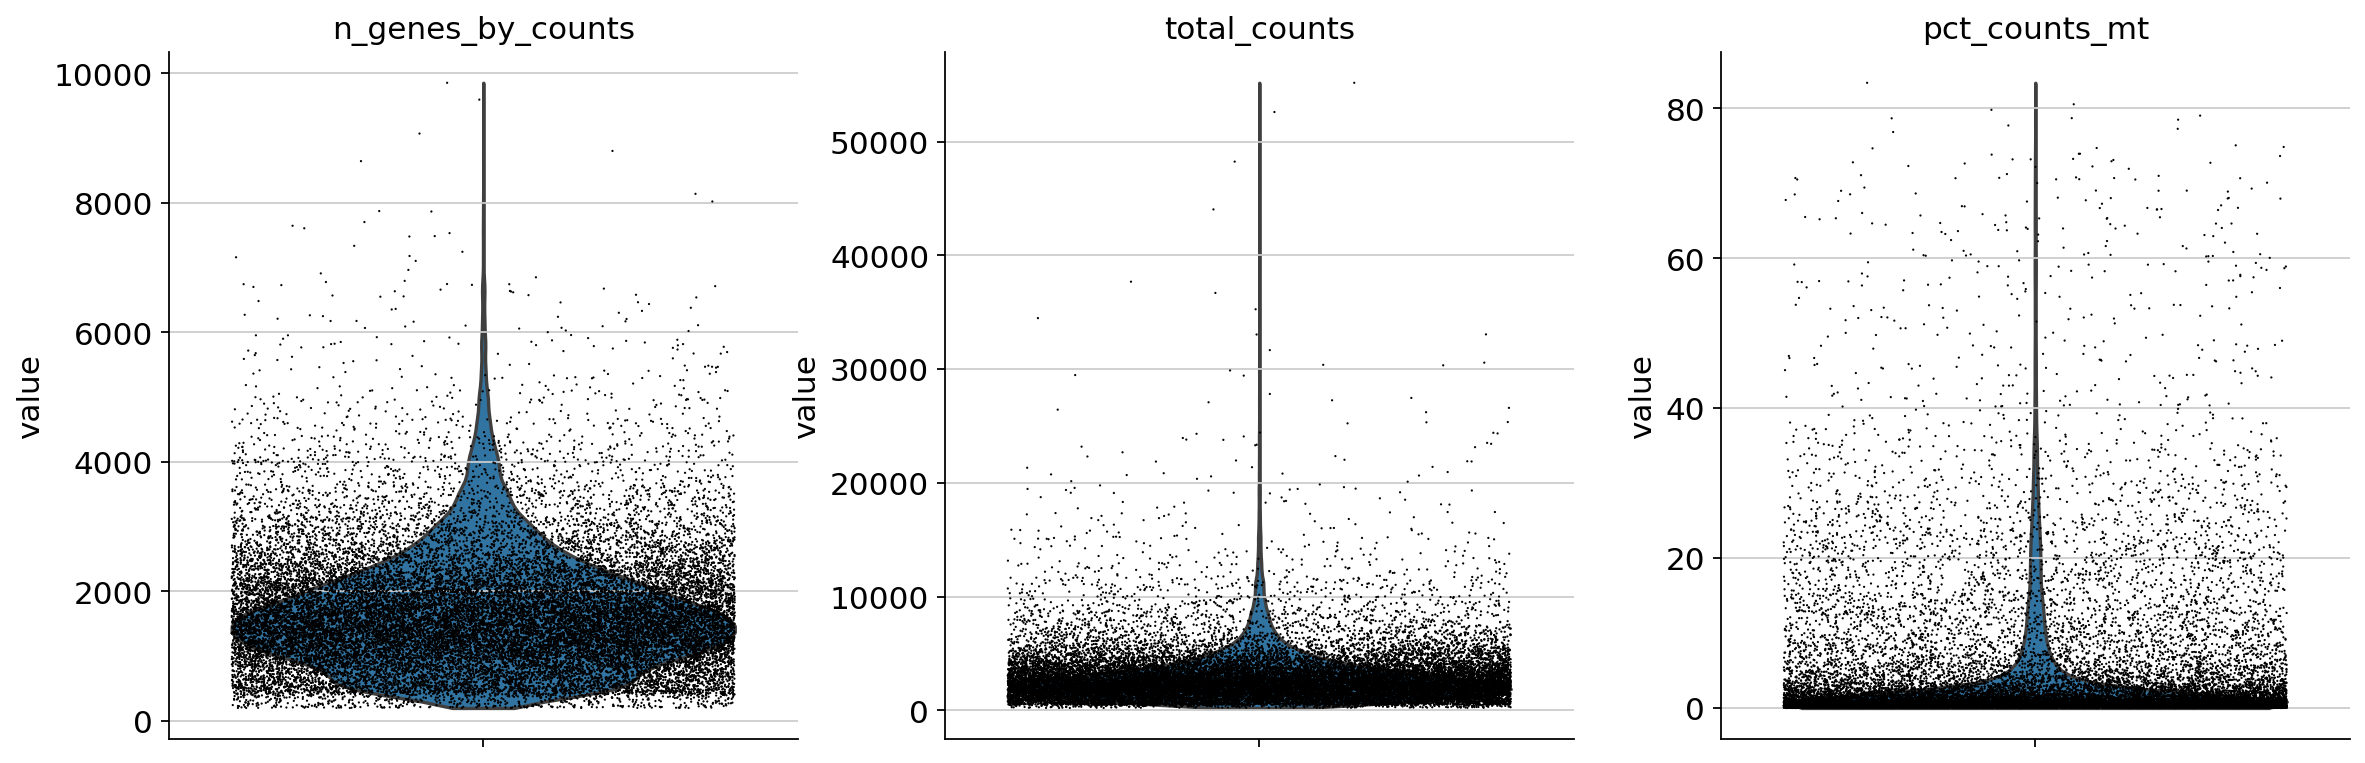

In [26]:
sc.pl.violin(adata_combined, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True)

## Normalization
It is important to normalize our data. Since we are combining different datasets and have done some filtering, we want to make sure that no genes or cells are over represented. Therefore we going to normalize on a per cell basis by essentially dividing all gene counts by the total count data for every cell. 

We will also put them on a log basis to make visualization easier. Just note this for future visualizations.

In [27]:
# Normalize the data
def normalize_data(runnning_on):
    for item in running_on:
        sc.pp.normalize_total(item, target_sum=1e4)

# Putting on a log scale
def log1p(running_on):
    for item in running_on:
        sc.pp.log1p(item)



In [28]:
# Aprrox. 0.5 sec per group
normalize_data(running_on)

normalizing counts per cell
    finished (0:00:00)


In [29]:
# Aprrox. 0.5 sec per group
log1p(running_on)

## Variable genes
As we are looking at differentiation, we care most about genes that are highly variable across cells, so we are going to focus on those for initial PCA.

In [30]:

# Find variable genes to do anaylsis on
sc.pp.highly_variable_genes(adata_combined, min_mean=0.0125, min_disp=0.5, batch_key='batch')



extracting highly variable genes


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas

    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


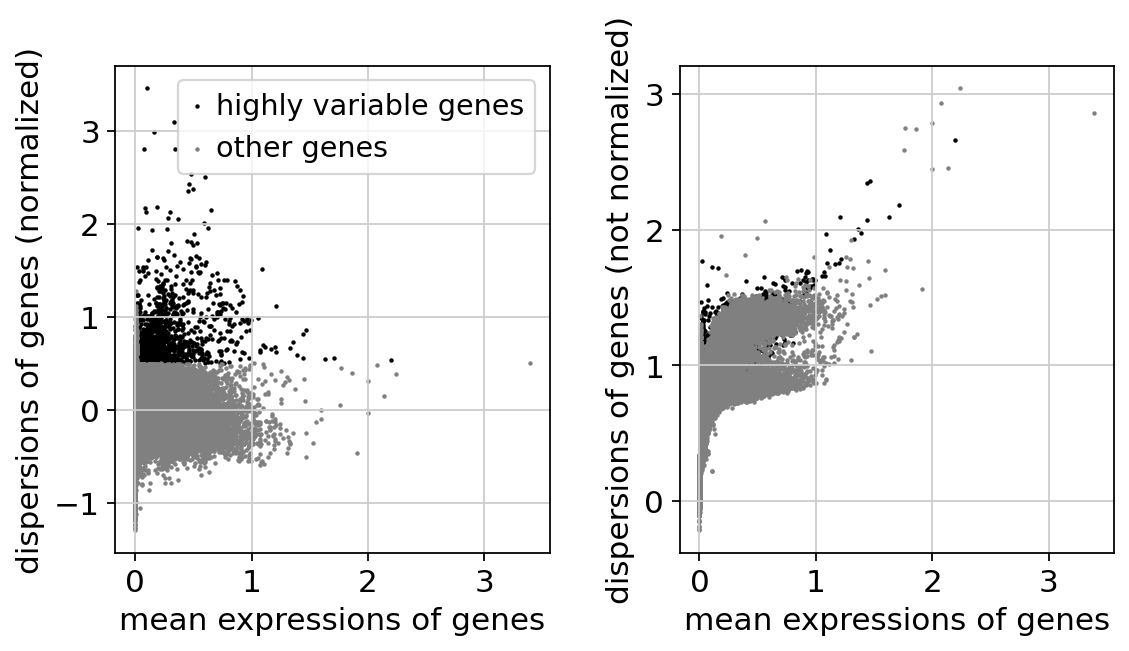

In [31]:
# quick visualisation of the highly variable genes
sc.pl.highly_variable_genes(adata_combined)


## Filtering Again
We are going to filter to only our highly variable genes. We are going to save a copy of our inclusive filtered data later under 'raw'.

In [32]:
def save_raw(running_on):
    for item in running_on:
        item.raw = item

# Aprrox. 0.1 sec per group
save_raw(running_on)




In [33]:
def filter_highly_variable(running_on):
    for item in running_on:
        item = item[:, item.var.highly_variable]

# Aprrox. 0.5 sec per group
filter_highly_variable(running_on)

In [34]:
adata_combined.var

,gene_ids-1914_human,feature_types-1914_human,genome-1914_human,gene_ids-1914_rat,feature_types-1914_rat,genome-1914_rat,gene_ids-1914d_human,feature_types-1914d_human,genome-1914d_human,gene_ids-1914d_rat,...,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
0610030E20Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000011713,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000011713,...,50,0.002149,99.800979,54.0,False,0.384374,1.320544,0.212324,2,False
1110038F14Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000034107,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000034107,...,7,0.000279,99.972137,7.0,False,0.057620,0.994139,0.160746,1,False
1110065P20Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000042421,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000042421,...,4,0.000159,99.984078,4.0,False,0.026443,0.624520,0.007281,0,False
1600012H06Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000070184,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000070184,...,11,0.000478,99.956215,12.0,False,0.110963,1.068014,0.207829,1,False
1600014C10Rik,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000014966,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000014966,...,2,0.000119,99.992039,3.0,False,0.013784,0.331926,0.045894,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000050321,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000050321,...,24,0.000995,99.904470,25.0,False,0.192318,1.064874,0.093402,1,False
mrpl11,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000019970,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000019970,...,4,0.000159,99.984078,4.0,False,0.042282,0.764489,-0.190811,2,False
mrpl24,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000022234,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000022234,...,38,0.001632,99.848744,41.0,False,0.370981,1.330238,-0.073480,1,False
mrpl9,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000020869,Gene Expression,mRatBN7.2,NaN,NaN,NaN,mRatBN7.2_ENSRNOG00000020869,...,14,0.000637,99.944274,16.0,False,0.102254,0.985850,0.034782,1,False


## Regressing out Variation
We are also going to regress out any (hopefully) unwanted sources of variation. This should be pretty safe, but we may want to check out what things look like without that.

### Note:
This can take up to 10+ minutes, so avoid rerunning when you don't need to.


In [35]:
def regress_out(running_on):
    for item in running_on:
        sc.pp.regress_out(item, ['total_counts', 'pct_counts_mt'])
        
# Aprrox. 2 minutes per group
# regress_out(running_on)

In [36]:
# Optionally we can also scale the data, making sure everything is below max

def scale_data(running_on, max=10):
    for item in running_on:
        sc.pp.scale(item, max_value=max)

# Aprrox. 1 sec per group
scale_data(running_on)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## PCA Analayis
A classic tool to visualizing our data is PCA Analysis. This can take up to 1 minute per sample.

In [37]:
def do_pca(running_on):
    for item in running_on:
        sc.tl.pca(item, svd_solver='arpack')

# Aprrox. 40 sec per group
do_pca(running_on)



computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


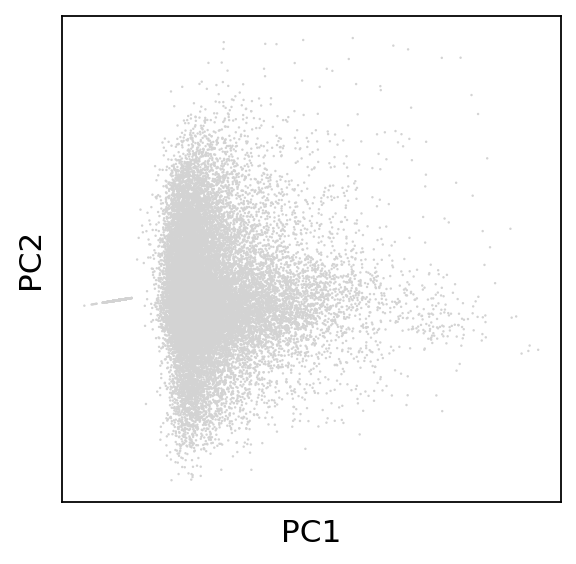

In [38]:
# plotting pca, we should use color...
sc.pl.pca(adata_combined)


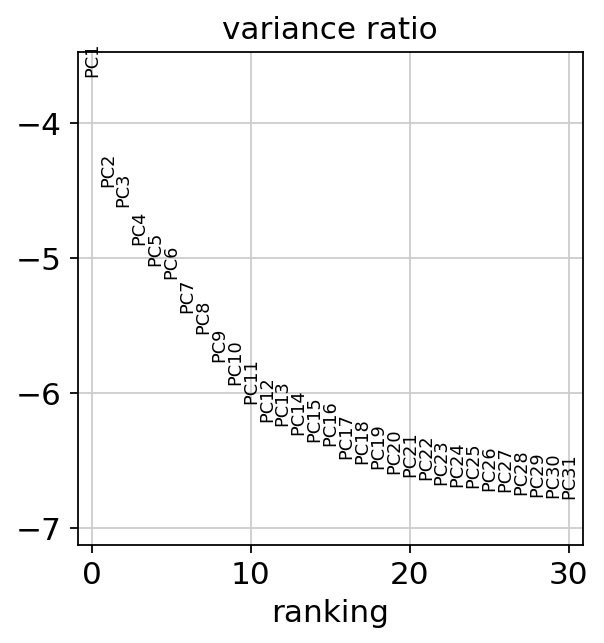

In [39]:
# Taking a look at how impactful each principal component is
sc.pl.pca_variance_ratio(adata_combined, log=True)

In [40]:
write_results(running_on, saving_to) 


Wrote to write/total_combined.h5ad


## Nearest Neighbour
This is one of the most important steps of single cell analysis, nearest neighbour analysis.

In [41]:
def do_nearest_neighbour(running_on):
    for item in running_on:
        sc.pp.neighbors(item, n_neighbors=25, n_pcs=40)

# Aprrox. 10 sec per group
do_nearest_neighbour(running_on)



computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


## Subgrouping
We are going to use the leiden algorithim to group into subgroups.

In [42]:
!pip3 install leidenalg | grep -v 'Requirement already satisfied'
!pip3 install louvain

In [43]:
def do_leiden(running_on):
    for item in running_on:
        sc.tl.leiden(item)

# Aprrox. 5 sec per group
do_leiden(running_on)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)


In [44]:
def do_louvain(running_on):
    for item in running_on:
        sc.tl.louvain(item)

In [45]:
do_louvain(running_on)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:06)


## Manifold Construction
There are a number of methods to do manifold construction, there are three below: tSNE, UMAP, and PAGA (for QC).

In [46]:
plot = False

def do_paga(running_on):
    for item in running_on:
        sc.tl.paga(item)
        sc.pl.paga(item, plot=plot)

# Aprrox. 0.5 sec per group
do_paga(running_on)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


## UMAP or tSNE
I prefer UMAP as it preserves data better, but tSNE results in better graphics as it throws away data that is usually noise.

In [47]:

def do_umap(running_on):
    for item in running_on:
      sc.tl.umap(item)
    
# Aprrox. 15 sec per group
do_umap(running_on)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


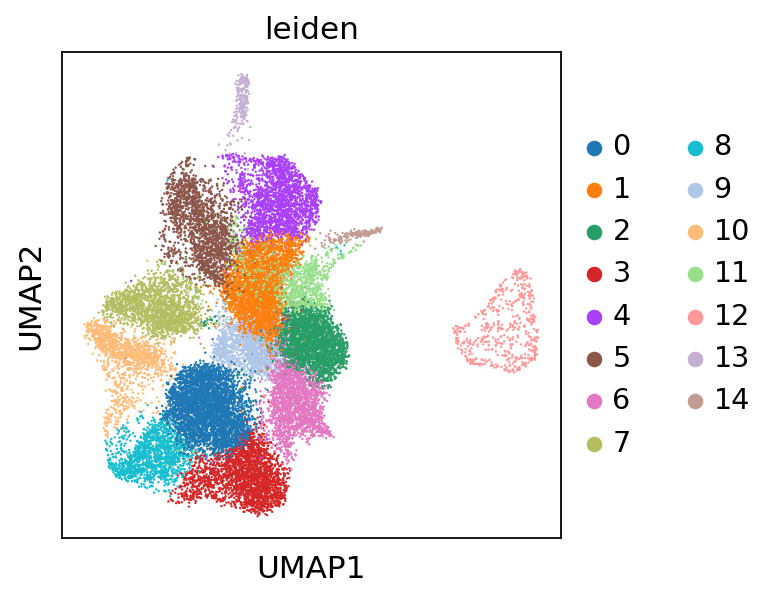

In [48]:
use_raw = False
color = ['leiden']
sc.pl.umap(adata_combined, color=color, use_raw=use_raw)


## tSNE
Below is tSNE for convenience sake.

In [50]:
def do_tsne(running_on):
    for item in running_on:
        sc.tl.tsne(item)
        

# Aprrox. 1.5 minutes per group
do_tsne(running_on)


computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:17)


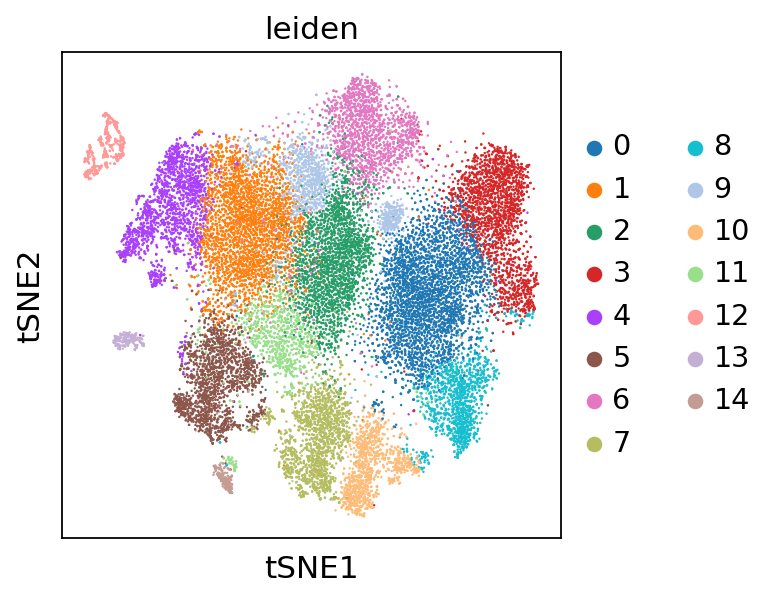

In [51]:
use_raw = False
color = ['leiden']

# plotting tsne
sc.pl.tsne(adata_combined, color=color, use_raw=use_raw)

In [52]:
write_results(running_on, saving_to)


Wrote to write/total_combined.h5ad


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


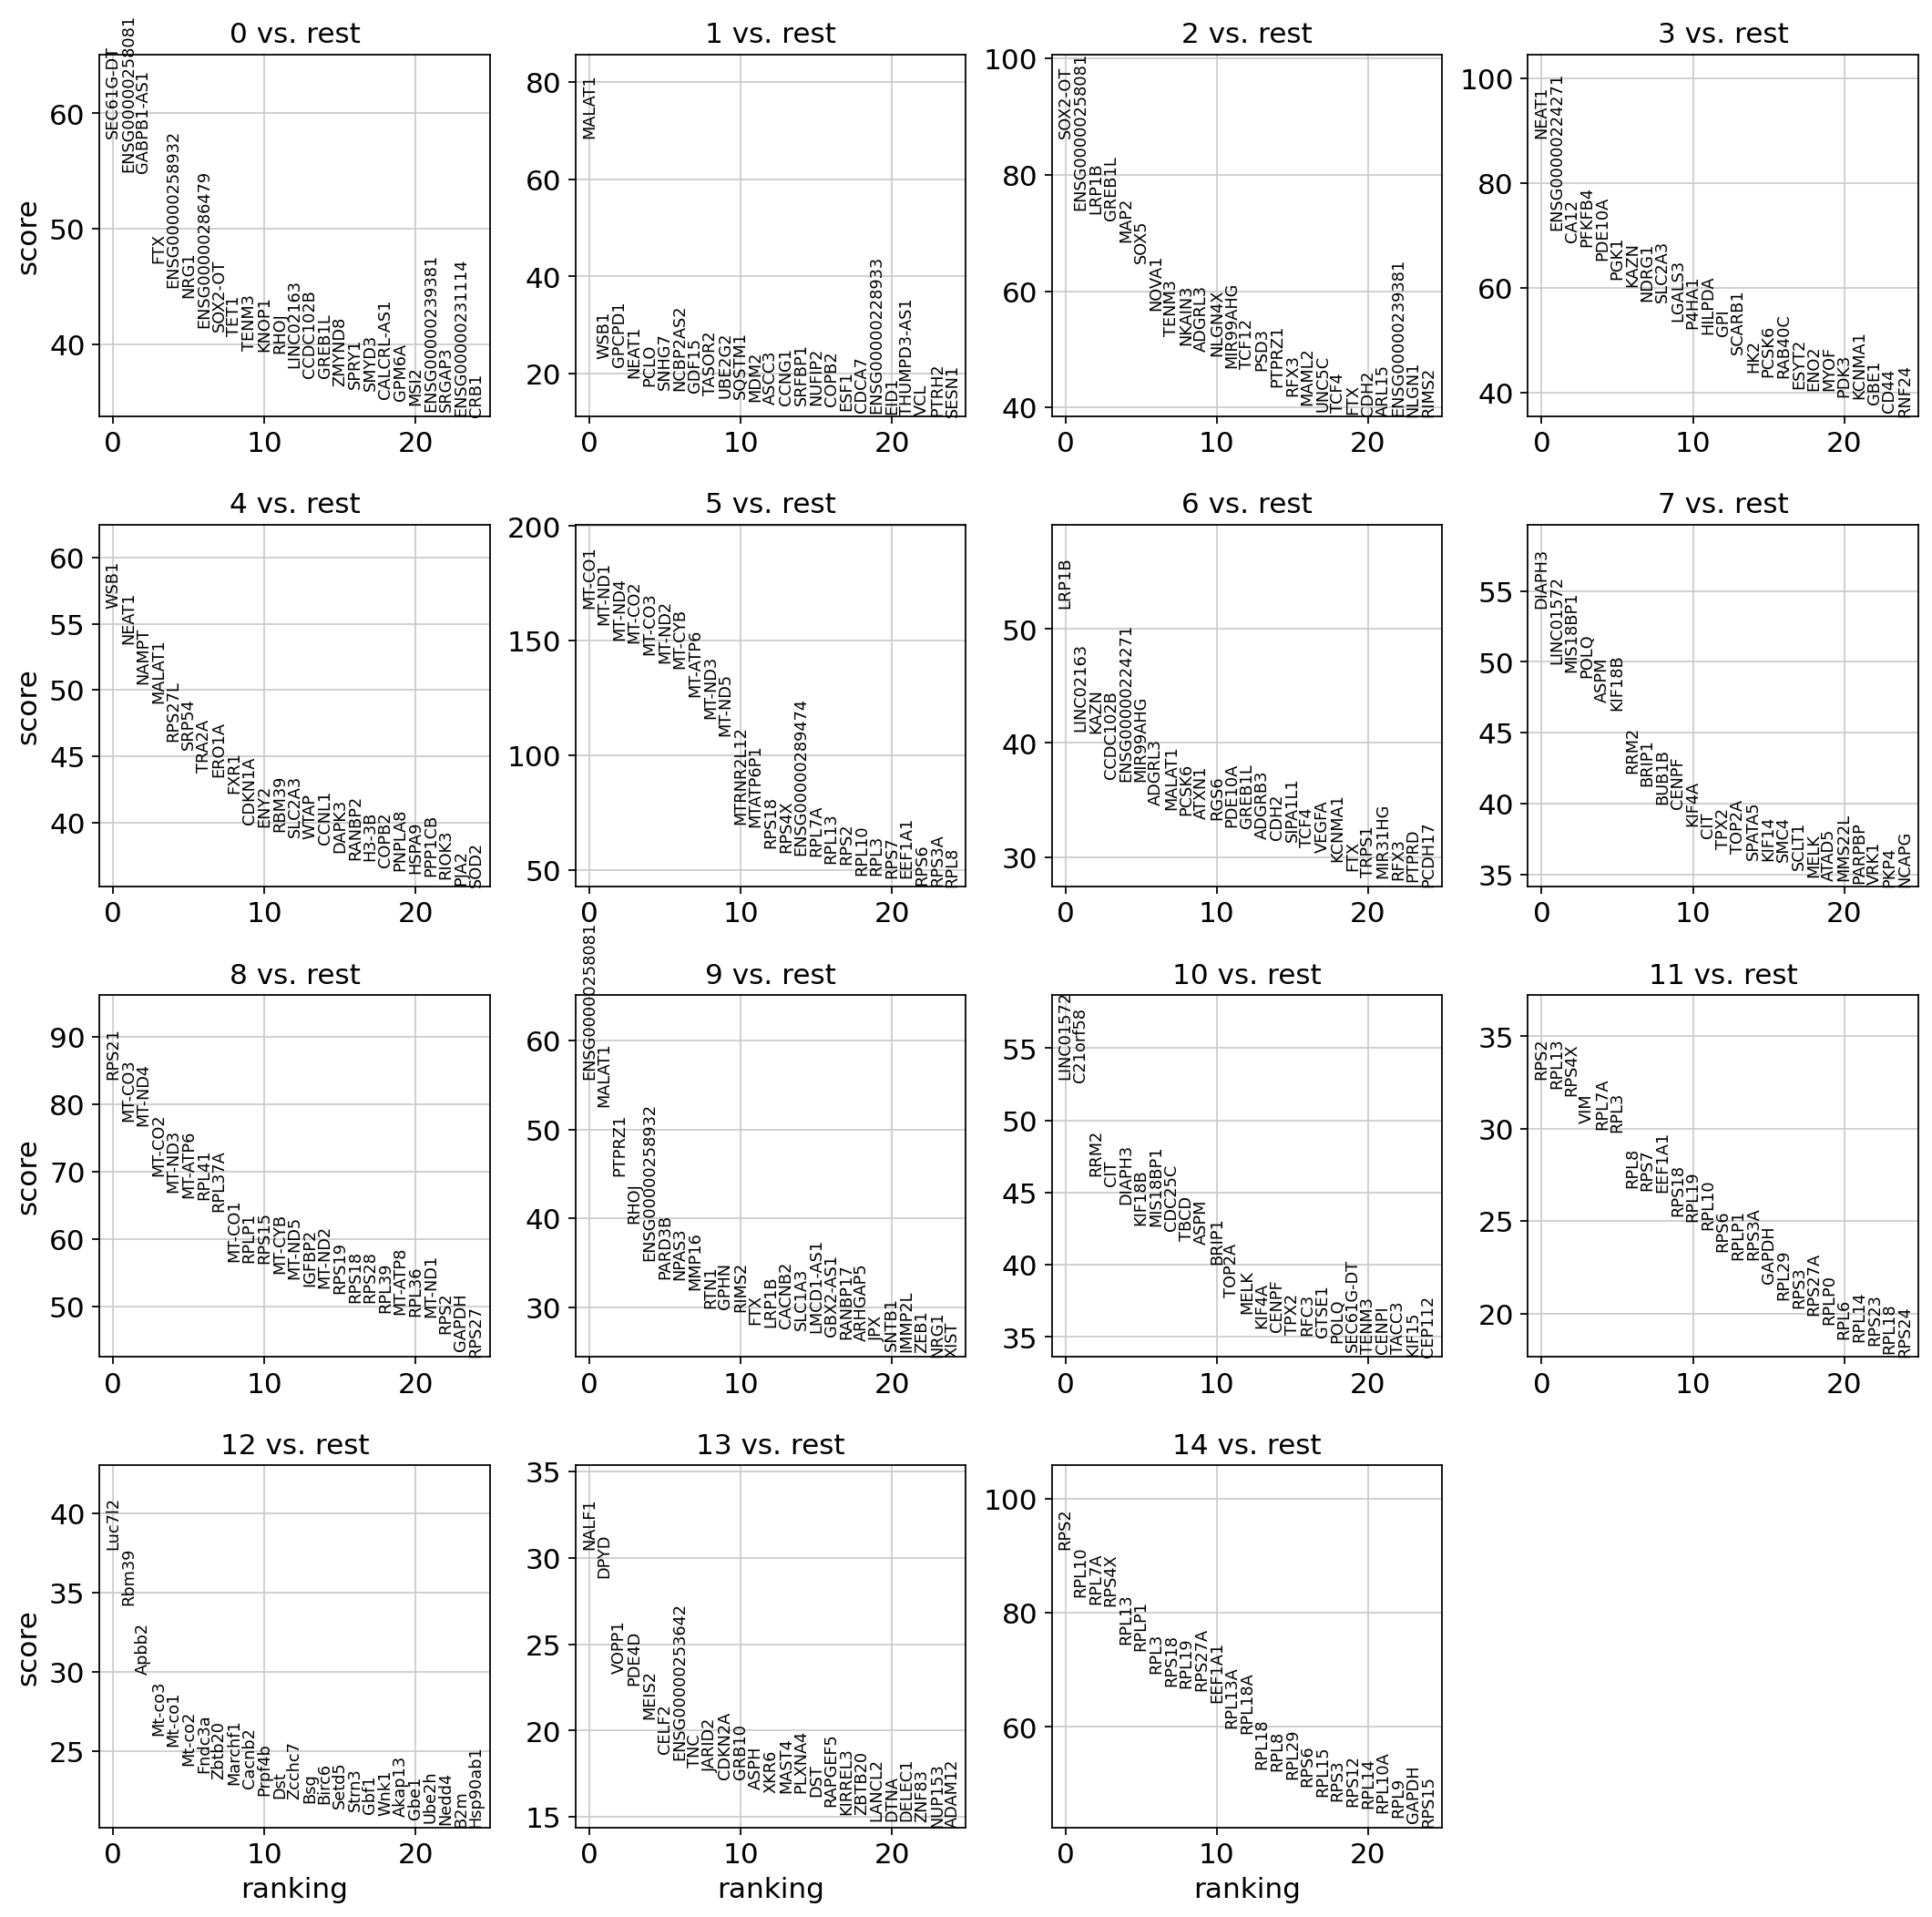

In [53]:
number_of_genes = 25
method = "t-test" # an alternative to try is wilconxon

def rank_gene_groups(running_on):
    for item in running_on:
        sc.tl.rank_genes_groups(item, 'leiden', method=method)
        sc.pl.rank_genes_groups(item, n_genes=number_of_genes, sharey=False, pts=True)

# Aprrox. 10 sec per group
rank_gene_groups(running_on)





In [54]:
write_results(running_on, saving_to)

Wrote to write/total_combined.h5ad


In [55]:
adata_combined.obs.batch

AAACCCACAAAGGAGA-1-1914_human    1914_human
AAACCCAGTTGTCCCT-1-1914_human    1914_human
AAACGAAAGCTCATAC-1-1914_human    1914_human
AAACGAAGTGTCCAAT-1-1914_human    1914_human
AAACGCTAGTAGTGCG-1-1914_human    1914_human
                                    ...    
TTGCGTCCAGGAGGAG-1-1919d_rat      1919d_rat
TTGTTGTAGTGGACGT-1-1919d_rat      1919d_rat
TTTCAGTGTCAGTCCG-1-1919d_rat      1919d_rat
TTTCCTCAGAGTTCGG-1-1919d_rat      1919d_rat
TTTGGTTCACGAGAAC-1-1919d_rat      1919d_rat
Name: batch, Length: 25123, dtype: category
Categories (8, object): ['1914_human', '1914_rat', '1914d_human', '1914d_rat', '1919_human', '1919_rat', '1919d_human', '1919d_rat']

# Starting Ontology Analysis
We are going to be training our own model using a glioblastoma dataset from the human atlas. This takes a computer with at least 100+ Gb of ?RAM. In order to train in a reasonable amount of time, do not do this on your own machine. It will probably crash. You will need to rent a computer on AWS or something.

I have excluded the code for training the model as I moved it to its own notebook.
Regardless, you should be able to simply import the pkl file which is the trained model.

In [ ]:
# # !pip3 install celltypist | grep -v 'Requirement already satisfied'
# import celltypist
# from celltypist import models
# new_model = models.Model.load('write/glioblastoma.pkl')
# new_model2 = models.Model.load('write/glioblastoma2.pkl')
# sc.pp.neighbors(backup3, n_neighbors=10, n_pcs=40)
# sc.tl.leiden(backup3, resolution=0.5, key_added='leiden')

# # predictions = celltypist.annotate(backup3, model = new_model2, majority_voting=True, mode="prob match", p_thres=0, min_prop=0.5)
# predictions2 = celltypist.annotate(backup3, model = new_model, majority_voting=True, mode="prob match", p_thres=0.01, min_prop=0.01, over_clustering="leiden")

# result = predictions2.to_adata(insert_prob=True)
# predictions_downsampled = celltypist.samples.downsample_adata(backup3, mode="each", by='majority_voting', n_cells = 100, balance_cell_type=True, return_index=False)

# result2 = predictions_downsampled.copy()

# celltypist.dotplot(predictions, use_as_reference='leiden', use_as_prediction="predicted_labels", show=True)

# sc.pp.neighbors(result2, n_neighbors=10, n_pcs=40)

# sc.tl.umap(result)
# sc.pl.umap(result, color = ['predicted_labels', 'leiden'])
# sc.pl.umap(result, color = ['majority_voting'])

# sc.tl.tsne(result)
# sc.pl.tsne(result, color = ['predicted_labels'])

# sc.pl.tsne(result, color = ['majority_voting'])

# sc.tl.umap(result, min_dist=1.0, spread = 2.0)
# sc.pl.umap(result, color = ['astrocyte', 'radial glial cell', 'oligodendrocyte precursor cell', 'oligodendrocyte', 'neuron','mural cell', 'monocyte', 'microglial cell' ])

# sc.tl.tsne(result)
# sc.pl.tsne(result, color = ['astrocyte', 'radial glial cell', 'oligodendrocyte precursor cell', 'oligodendrocyte', 'neuron','mural cell', 'monocyte', 'microglial cell' ])






[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [3]:
adata_combined = sc.read_h5ad('write/total_combined.h5ad')

In [4]:
adata_ref = sc.read_h5ad('local.h5ad', chunk_size=500, backed=True)

: 

: 

In [ ]:
var_names = adata_ref.var_names.intersection(adata_combined.var_names)
adata_ref = adata_ref[:, var_names]
adata_combined = adata_combined[:, var_names]

In [ ]:
sc.tl.ingest(adata_combined, adata_ref, obs='louvain')
adata_combined.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors
sc.pl.umap(adata_combined, color=['louvain', 'bulk_labels'], wspace=0.5)


In [ ]:
adata_concat = adata_ref.concatenate(adata_combined, batch_categories=['ref', 'new'])
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors

## Rat vs Human 
Seeing if seperating out rat from human in 1914 + 1914d has any important effects.
Result: It does not.

In [ ]:
adata_1914d_human = sc.read_10x_h5(
    '1914d/outs/filtered_feature_bc_matrix.h5',
    genome='GRCh38') 
adata_1914_human = sc.read_10x_h5(
    '1914/outs/filtered_feature_bc_matrix.h5',
    genome='GRCh38')


reading 1914d/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading 1914/outs/filtered_feature_bc_matrix.h5


/opt/homebrew/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/opt/homebrew/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
adata_1914_human.var_names = [name[10:] for name in adata_1914_human.var_names]
adata_1914d_human.var_names = [name[10:] for name in adata_1914d_human.var_names]
# make the gene names unique
adata_1914_human.var_names_make_unique()
adata_1914d_human.var_names_make_unique()

In [ ]:
adata_1914_human_combined = adata_1914_human.concatenate(adata_1914d_human, join='outer', batch_key='batch', batch_categories=['1914', '1914d'])


/opt/homebrew/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
sc.pp.filter_cells(adata_1914_human_combined, min_genes=200)
sc.pp.filter_genes(adata_1914_human_combined, min_cells=2)


filtered out 8250 cells that have less than 200 genes expressed
filtered out 22210 genes that are detected in less than 2 cells


In [ ]:
adata_1914_human_combined.var['mt'] = adata_1914_human_combined.var_names.str.startswith('MT-') 

# compute QC metrics for all datasets
sc.pp.calculate_qc_metrics(adata_1914_human_combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
adata_1914_human_combined = adata_1914_human_combined[adata_1914_human_combined.obs.n_genes_by_counts < 2500, :]
adata_1914_human_combined = adata_1914_human_combined[adata_1914_human_combined.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.normalize_total(adata_1914_human_combined, target_sum=1e4)

# Putting on a log scale
sc.pp.log1p(adata_1914_human_combined)

# Find variable genes
sc.pp.highly_variable_genes(adata_1914_human_combined, min_mean=0.0125, min_disp=0.5)
adata_1914_human_combined = adata_1914_human_combined[:, adata_1914_human_combined.var.highly_variable]

sc.pp.neighbors(adata_1914_human_combined, n_neighbors=25, n_pcs=40)
sc.tl.leiden(adata_1914_human_combined)
sc.tl.umap(adata_1914_human_combined)




normalizing counts per cell
    finished (0:00:00)


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


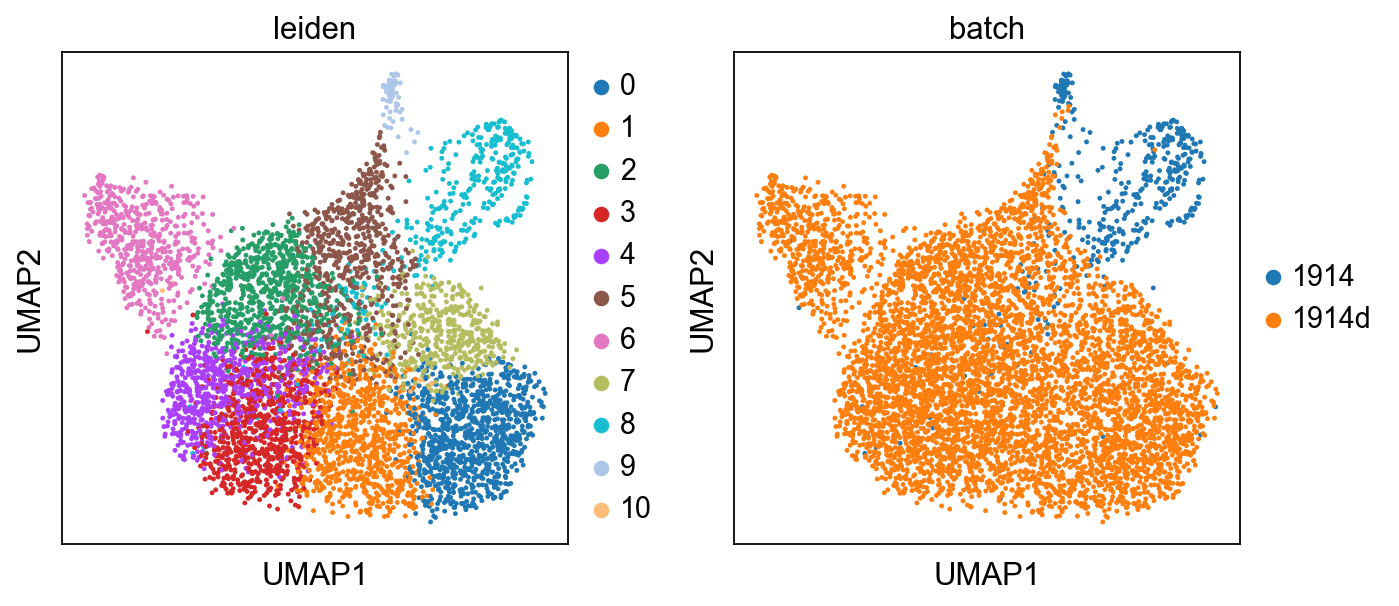

In [ ]:
sc.pl.umap(adata_1914_human_combined, color=['leiden', 'batch'])